In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Figure 1 of the nano-COP manuscript. 

                                            
#####

samples for short-read Illumina sequencing

tot = total RNA
chr = chromatin associated RNA
4sU = 4sU metabolically labeled and selected RNA
4sUchr = 4sU labeled chromatin associated RNA

"""

In [1]:
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
sns.set_style("white")

import matplotlib.pyplot as plt
import re
% matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

import math

from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, chi2_contingency
from scipy.special import stdtr

import pybedtools
from pybedtools import BedTool

In [2]:
# make a function to calculate the percent of spliced molecules over a 3'SS junction
def calculate_SI (count_5SS, count_3SS, count_splice):
    dividend = 2 * count_splice
    divisor = count_5SS + count_3SS
    if (divisor != 0):
        result = dividend/divisor
    if (divisor == 0 and dividend == 0):
        result = 0.0
    if (divisor == 0 and dividend != 0):
        result = "Inf"
    return result


# make a function to get all gene splicing index values for a sample
# threshold indicates the total number of reads that need to span the junctions
# within a gene to count
def get_SI(sample_name, threshold): 
    # make empty gene matrix list
    gene_matrix=[]
    
    # get splice count values as a dataframe from SI counts file
    SI_df = pd.read_table("/path/to/%s_SI_counts.txt" %sample_name, \
                          dtype={"gene": str, "intron": int, "chr":str, "start": int, "end": int, \
                                 "strand": str, "5SS_count": float, "3SS_count": float, "splice_count": float})

    # sum all unspliced reads spanning the 5'SS in every gene
    sum_5SS = pd.DataFrame(SI_df.groupby('gene')['5SS_count'].sum())
    sum_5SS.index.name = 'gene'
    sum_5SS.reset_index(inplace=True)

    # sum all unspliced reads spanning the 5'SS in every gene    
    sum_3SS = pd.DataFrame(SI_df.groupby('gene')['3SS_count'].sum())
    sum_3SS.index.name = 'gene'
    sum_3SS.reset_index(inplace=True)

    # sum all spliced reads spanning exon juctions in every gene    
    sum_splice = pd.DataFrame(SI_df.groupby('gene')['splice_count'].sum())
    sum_splice.index.name = 'gene'
    sum_splice.reset_index(inplace=True)

    # make a dataframe with all splicing information coverage information for each gene
    gene_matrix=pd.merge(sum_5SS,sum_3SS,on="gene")
    gene_matrix=pd.merge(gene_matrix,sum_splice,on="gene")
    gene_matrix.columns = ['gene','sum_5SS','sum_3SS','sum_splice']

    # remove genes that do not reach the threshold
    gene_matrix = gene_matrix[(gene_matrix['sum_5SS']+gene_matrix['sum_3SS']+gene_matrix['sum_splice'])>threshold]

    # remove genes that have 0 in either the denominator or numerator of the splicing index
    gene_matrix = gene_matrix[(gene_matrix['sum_5SS']+gene_matrix['sum_3SS'])>0]
    gene_matrix = gene_matrix[gene_matrix['sum_splice']>0]

    # an alternative way of dealing with zeros is to add a pseudocount
    # this doesn't change the results much and adds inaccurate fliers to the plot
    #gene_matrix = gene_matrix.replace(0.0, 0.1)
    
    # get the percent spliced value for each gene and add to matrix
    gene_matrix['SI'] = gene_matrix.apply(lambda row: calculate_SI(row.sum_5SS,row.sum_3SS,row.sum_splice), axis=1)   

    # get the log of the percent spliced values for each gene and add to matrix
    gene_matrix['log_SI'] = gene_matrix.apply(lambda row: np.log10(row.SI), axis=1)   
    
    return gene_matrix


# make a function to make a large SI count dataframe from combined replicates
def combining_reps(sample_1,sample_2): 
    # make empty gene matrix list
    gene_matrix=[]
    
    # get splice count values as a dataframe from SI counts file
    SI_df_1 = pd.read_table("/path/to/%s_SI_counts.txt" %sample_1, \
                          dtype={"gene": str, "intron": int, "chr":str, "start": int, "end": int, \
                                 "strand": str, "5SS_count": float, "3SS_count": float, "splice_count": float})

    SI_df_2 = pd.read_table("/path/to/%s_SI_counts.txt" %sample_2, \
                      dtype={"gene": str, "intron": int, "chr":str, "start": int, "end": int, \
                             "strand": str, "5SS_count": float, "3SS_count": float, "splice_count": float})

    count_5SS = SI_df_1['5SS_count']+SI_df_2['5SS_count']
    count_3SS = SI_df_1['3SS_count']+SI_df_2['3SS_count']
    count_splice = SI_df_1['splice_count']+SI_df_2['splice_count']

    SI_df=SI_df_1
    SI_df['5SS_count']=count_5SS
    SI_df['3SS_count']=count_3SS
    SI_df['splice_count']=count_splice
    
    return SI_df


# make a function to get all gene splicing index values for a sample
# threshold indicates the total number of reads that need to span the junctions
# within a gene to count
def get_combined_SI(sample_name, threshold): 
    # make empty gene matrix list
    gene_matrix=[]
    
    # get splice count values as a dataframe from SI counts file
    SI_df = sample_name

    # sum all unspliced reads spanning the 5'SS in every gene
    sum_5SS = pd.DataFrame(SI_df.groupby('gene')['5SS_count'].sum())
    sum_5SS.index.name = 'gene'
    sum_5SS.reset_index(inplace=True)

    # sum all unspliced reads spanning the 5'SS in every gene    
    sum_3SS = pd.DataFrame(SI_df.groupby('gene')['3SS_count'].sum())
    sum_3SS.index.name = 'gene'
    sum_3SS.reset_index(inplace=True)

    # sum all spliced reads spanning exon juctions in every gene    
    sum_splice = pd.DataFrame(SI_df.groupby('gene')['splice_count'].sum())
    sum_splice.index.name = 'gene'
    sum_splice.reset_index(inplace=True)

    # make a dataframe with all splicing information coverage information for each gene
    gene_matrix=pd.merge(sum_5SS,sum_3SS,on="gene")
    gene_matrix=pd.merge(gene_matrix,sum_splice,on="gene")
    gene_matrix.columns = ['gene','sum_5SS','sum_3SS','sum_splice']

    # remove genes that do not reach the threshold
    gene_matrix = gene_matrix[(gene_matrix['sum_5SS']+gene_matrix['sum_3SS']+gene_matrix['sum_splice'])>threshold]

    # remove genes that have 0 in either the denominator or numerator of the splicing index
    gene_matrix = gene_matrix[(gene_matrix['sum_5SS']+gene_matrix['sum_3SS'])>0]
    gene_matrix = gene_matrix[gene_matrix['sum_splice']>0]

    # get the percent spliced value for each gene and add to matrix
    gene_matrix['SI'] = gene_matrix.apply(lambda row: calculate_SI(row.sum_5SS,row.sum_3SS,row.sum_splice), axis=1)   

    # get the log of the percent spliced values for each gene and add to matrix
    gene_matrix['log_SI'] = gene_matrix.apply(lambda row: np.log10(row.SI), axis=1)   
    
    return gene_matrix


# get the feature count for each sample
def get_featureCount(sample_name): 
    
    # make empty gene matrix list
    featureCount_df = pd.read_table("/path/to/%s_featureCount.txt" %sample_name)
    featureCount_df = featureCount_df[featureCount_df['gene_RPKM']>0]
    featureCount_df = featureCount_df[featureCount_df['exon_RPKM']>0]
    featureCount_df = featureCount_df[featureCount_df['intron_RPKM']>0]

    return featureCount_df


# get the feature count for each sample
def get_uniq_featureCount(sample_name): 
    
    # make empty gene matrix list
    featureCount_df = pd.read_table("/path/to/%s_uniq_featureCount.txt" %sample_name)
    featureCount_df = featureCount_df[featureCount_df['gene_RPKM']>0]
    featureCount_df = featureCount_df[featureCount_df['exon_RPKM']>0]
    featureCount_df = featureCount_df[featureCount_df['intron_RPKM']>0]

    return featureCount_df


# separate RPKM values by percentiles for plotting
def get_percentile(x, df):
    
    bottom_10 = np.percentile(df['log_RPKM'], 10)
    top_10 = np.percentile(df['log_RPKM'], 90)

    bottom_25 = np.percentile(df['log_RPKM'], 25)
    top_25 = np.percentile(df['log_RPKM'], 75)

    median = np.percentile(df['log_RPKM'], 50)

    if (x < median):
        value = '<50'
    if (x >= median and x < top_25):
        value = '50-75'
    if (x >= top_25 and x < top_10):
        value = '75-90'
    if (x >= top_10):
        value = '>90'    
    
    return value


def get_read_end_stats(read_ends):
    
    read_features = []

    for k, v in read_ends.items():

        if (len(v) == 1):
            read_features.append([k,v[0]])

        if (len(v) > 1):
            if ("polyA" in v):
                read_features.append([k,"polyA"])

            elif ("post_polyA" in v):
                read_features.append([k,"post_polyA"])

            elif ("intron_SS" in v):
                read_features.append([k,"splice_site"])

            elif ("RNAPET" in v):
                read_features.append([k,"RNAPET"])

            else:
                read_features.append([k,"undetermined"])

    read_features_df = pd.DataFrame(read_features)
    read_features_df.columns = ['read','end_feature']
    
    return read_features_df


def get_pie_chart_df(read_features_df,read_ends_bedtool):

    pie_chart = []
    pie_chart.append(['exon',len(read_features_df[read_features_df['end_feature']=='exon'])])
    pie_chart.append(['splice_site',len(read_features_df[read_features_df['end_feature']=='splice_site'])])
    pie_chart.append(['intron',len(read_features_df[read_features_df['end_feature']=='intron'])])
    pie_chart.append(['polyA',len(read_features_df[read_features_df['end_feature']=='polyA'])+len(read_features_df[read_features_df['end_feature']=='RNAPET'])])
    pie_chart.append(['post_polyA',len(read_features_df[read_features_df['end_feature']=='post_polyA'])])
    #pie_chart.append(['RNAPET',len(read_features_df[read_features_df['end_feature']=='RNAPET'])])
    pie_chart.append(['other',len(read_ends_bedtool.to_dataframe())-len(read_features_df)])
    pie_chart.append(['undetermined',len(read_features_df[read_features_df['end_feature']=='undetermined'])])
    pie_chart_df = pd.DataFrame(pie_chart)
    pie_chart_df = pie_chart_df.set_index([0])
    pie_chart_df.columns = ['count']
    pie_chart_df
    
    return pie_chart_df

In [17]:
# FIGURE 1B - splicing index by RPKM from Illumina RNA-seq data - replicate #1

# make a variable for threshold
t = 25

# get splicing index values for all samples
chr_1_SI = get_SI('chr_1', t)
lab_1_SI = get_SI('4sU_1', t)
labchr_1_SI = get_SI('4sUchr_1', t)

# Make a dataframe that can be used to compare splicing index vs. feature count

# get feature count values for total RNA
tot_1_featureCount = get_featureCount('tot_1')

# merge all samples to make sure we are comparing the same genes
merged_genes = pd.merge(tot_1_featureCount,chr_1_SI,on=['gene'],how="inner")
merged_genes = pd.merge(merged_genes,lab_1_SI,on=['gene'],how="inner")
merged_genes = pd.merge(merged_genes,labchr_1_SI,on=['gene'],how="inner")[['gene','gene_count','exon_count','intron_count','gene_RPKM','exon_RPKM','intron_RPKM','exon_intron_ratio']]

# merge dataframes to plot splicing index vs. feature count comparisons
chr_merge = pd.merge(chr_1_SI,merged_genes,on=['gene'],how="inner")[['gene','exon_RPKM','log_SI']]
chr_merge['name']="chr"
lab_merge = pd.merge(lab_1_SI,merged_genes,on=['gene'],how="inner")[['gene','exon_RPKM','log_SI']]
lab_merge['name']="4sU"
labchr_merge = pd.merge(labchr_1_SI,merged_genes,on=['gene'],how="inner")[['gene','exon_RPKM','log_SI']]
labchr_merge['name']="4sU+chr"

merge = pd.concat([chr_merge,lab_merge,labchr_merge]).reset_index()
merge['log_RPKM'] = merge.apply(lambda row: np.log2(row.exon_RPKM), axis=1)   
merge['percentile'] = merge.apply(lambda row: get_percentile(row.log_RPKM, merge), axis=1)   


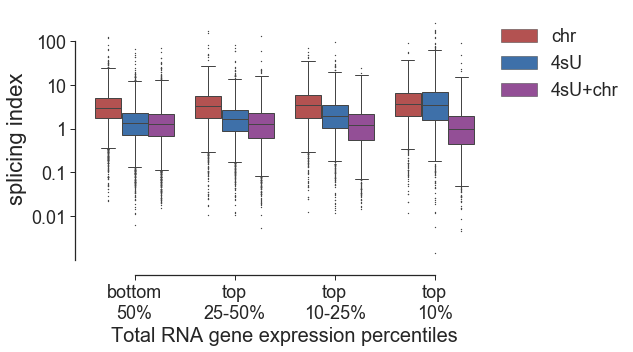

In [18]:

# plot figure
fig, ax = plt.subplots(figsize=(7,5))

fill_color=['reddish','medium blue','medium purple']
ax = sns.boxplot(x='percentile', y='log_SI' , hue='name', data=merge, order=['<50','50-75','75-90','>90'],
               width=0.8, linewidth=1, palette=sns.xkcd_palette(fill_color),fliersize=0.5)
sns.despine(offset=10, trim=True)

# label y axis
plt.ylabel("splicing index", fontsize=22)
y_labels = ["0.01","0.1","1","10","100"]
plt.yticks([-2,-1,0,1,2], y_labels, fontsize=18)

# label x axis
x_labels = ["bottom\n50%","top\n25-50%","top\n10-25%","top\n10%"]
plt.xticks([0,1,2,3], x_labels, fontsize=18)
plt.xlabel("Total RNA gene expression percentiles", fontsize=20)

# add ticks to axes
ax.tick_params(direction='out', length=5, width=1)

# add legend
plt.legend(fontsize = 18, bbox_to_anchor=(1, 1))

plt.tight_layout()

# save image for figure
plt.savefig('/path/to/Figure_1B_splicing_index_rep1.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

plt.show()



In [37]:
N=len(merge['gene'].unique())
print("Number of genes measured: "+str(N))


Number of genes measured: 9659


In [9]:

names = ['chr','4sU']
percentiles = ['<50','50-75','75-90','>90']

stats_list = []

for name in names:
    for percentile in percentiles:
        
        t, p = ttest_ind(merge[(merge['name']==name) & (merge['percentile']==percentile)]['log_SI'], merge[(merge['name']=='4sU+chr') & (merge['percentile']==percentile)]['log_SI'], nan_policy='omit', equal_var=False)

        stats_list.append([name, percentile, t, p])

Ttest_stats_df = pd.DataFrame(stats_list)
Ttest_stats_df.columns = ['name', 'percentile', 'T value', 'p value']

Ttest_stats_df


,name,percentile,T value,p value
0,chr,<50,44.325795,0.000000e+00
1,chr,50-75,30.880466,3.647812e-191
2,chr,75-90,25.807840,2.429460e-132
3,chr,>90,24.286822,8.318064e-114
4,4sU,<50,3.660559,2.530141e-04
5,4sU,50-75,9.460121,4.689584e-21
6,4sU,75-90,12.749407,2.911714e-36
7,4sU,>90,21.101478,6.475988e-89


In [10]:
names = ['chr','4sU']
percentiles = ['<50','50-75','75-90','>90']

stats_list = []

for name in names:
    for percentile in percentiles:
        
        t, p = stats.ks_2samp(merge[(merge['name']==name) & (merge['percentile']==percentile)]['log_SI'], merge[(merge['name']=='4sU+chr') & (merge['percentile']==percentile)]['log_SI'])

        stats_list.append([name, percentile, t, p])

KS_stats_df = pd.DataFrame(stats_list)
KS_stats_df.columns = ['name', 'percentile', 'KS value', 'p value']

KS_stats_df


,name,percentile,KS value,p value
0,chr,<50,0.410851,0.000000e+00
1,chr,50-75,0.411594,2.283887e-179
2,chr,75-90,0.440304,1.493847e-123
3,chr,>90,0.509317,1.707348e-110
4,4sU,<50,0.033754,7.936932e-03
5,4sU,50-75,0.133333,3.333569e-19
6,4sU,75-90,0.223602,3.522442e-32
7,4sU,>90,0.453416,1.168999e-87


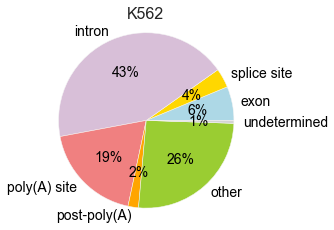

In [19]:
# FIGURE 1D - K562 (with polyA polymerase)  pie chart
# The input files were made with the script nanoCOP_pie_chart_datasets.ipynb

# read in files for making read end pie charts
K562_read_ends_df = pd.read_table('/path/to/K562_read_ends.txt')  
K562_read_ends = pybedtools.BedTool.from_dataframe(K562_read_ends_df)
K562_read_ends = K562_read_ends.saveas()
K562_read_ends_stats = pd.read_table('/path/to/K562_read_end_stats.txt')  

# make dataframe for pie chart
K562_pie_chart_df = get_pie_chart_df(K562_read_ends_stats, K562_read_ends)

# plot pie chart
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(3.5,3.5))

col_list = ['lightblue', 'gold', 'thistle', 'lightcoral', 'orange', 'yellowgreen', 'lightgray']
label_list=['exon','splice site','intron','poly(A) site','post-poly(A)','other','undetermined']

wedges, texts, autotexts = ax.pie(K562_pie_chart_df, labels=label_list, colors=col_list, autopct='%1.0f%%')
ax.axis('equal')    # Equal aspect ratio ensures that pie is drawn as a circle
ax.set_title('K562', fontsize=16)

for text in texts:
    text.set_color('black')
    text.set_fontsize(14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(14)

for w in wedges:
    w.set_linewidth(0.5)
    w.set_edgecolor('whitesmoke')

plt.savefig('/path/to/Figure_1D_K562_wiA_3primeEnd_pie_chart.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')
    
#plt.tight_layout()
plt.show()


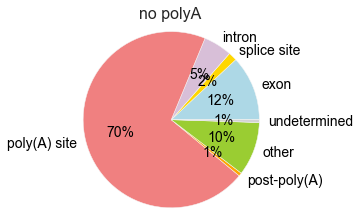

In [20]:
# FIGURE 1E - K562 (no polyA polymerase) pie chart
# The input files were made with the script nanoCOP_pie_chart_datasets.ipynb

# read in files for making read end pie charts
K562_no_tailing_read_ends_df = pd.read_table('/path/to/K562_no_tailing_read_ends.txt')  
K562_no_tailing_read_ends = pybedtools.BedTool.from_dataframe(K562_no_tailing_read_ends_df)
K562_no_tailing_read_ends = K562_no_tailing_read_ends.saveas()
K562_no_tailing_read_ends_stats = pd.read_table('/Users/hldrexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanopore_read_ends/K562_no_tailing_read_end_stats.txt')  

# make dataframe for pie chart
K562_no_tailing_pie_chart_df = get_pie_chart_df(K562_no_tailing_read_ends_stats, K562_no_tailing_read_ends)


# plot pie chart
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(3.5,3.5))

col_list = ['lightblue', 'gold', 'thistle', 'lightcoral', 'orange', 'yellowgreen', 'lightgray']
label_list=['exon','splice site','intron','poly(A) site','post-poly(A)','other','undetermined']

wedges, texts, autotexts = ax.pie(K562_no_tailing_pie_chart_df, labels=label_list, colors=col_list, autopct='%1.0f%%')
ax.axis('equal')    # Equal aspect ratio ensures that pie is drawn as a circle
ax.set_title('no polyA', fontsize=16)

for text in texts:
    text.set_color('black')
    text.set_fontsize(14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(14)

for w in wedges:
    w.set_linewidth(0.5)
    w.set_edgecolor('whitesmoke')

plt.savefig('/path/to/Figure_1E_K562_no_tailing_3primeEnd_pie_chart.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')
    
#plt.tight_layout()
plt.show()


In [24]:
### Statistics comparing alignment to poly(A) sites between + and - polyA polymerase samples

# get values for Fisher exact test and Chi squared test
minus_A = K562notailing_pie_chart_df.loc['polyA']['count']
minus_notailing = np.sum(K562notailing_pie_chart_df['count'])-K562notailing_pie_chart_df.loc['polyA']['count']
plus_A = K562_pie_chart_df.loc['polyA']['count']
plus_notailing = np.sum(K562_pie_chart_df['count'])-K562_pie_chart_df.loc['polyA']['count']

#np.array([[plus_A, plus_notailing], [minus_A, minus_notailing]])

oddsratio, pvalue = stats.fisher_exact([[plus_A, plus_notailing], [minus_A, minus_notailing]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[plus_A, plus_notailing], [minus_A, minus_notailing]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))


Fisher exact p-value: <2.2e-16
chi-square p-value: <2.2e-16


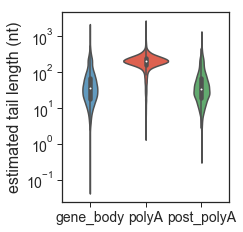

In [32]:
# FIGURE 1F - K562 (+polyA polymerase) poly(A) tail lengths

# The input files were obtained from the nanopolish poly(A) estimator

# K562 +poly(A) 
K562_1_nano = pd.read_csv('/path/to/K562_1.polyA_estimates.tsv', sep='\t', low_memory=False)
K562_2_nano = pd.read_csv('/path/to/K562_2.polyA_estimates.tsv', sep='\t', low_memory=False)
K562_3_nano = pd.read_csv('/path/to/K562_3.polyA_estimates.tsv', sep='\t', low_memory=False)

# concatenate all samples
K562_wiA_nano =  pd.concat([K562_1_nano,K562_2_nano,K562_3_nano]).reset_index(drop=True)

# Select only reads that passed the QC filter + remove reads when polya_length is equal to 0
K562_wiA_pass_df = K562_wiA_nano[(K562_wiA_nano['qc_tag'] == 'PASS') & (K562_wiA_nano['polya_length'] != 0.0)].reset_index(drop=True)

# Merge with nanopolish polyA estimator results
K562_read_ends_stats.columns = ['readname','end_feature']
K562_wiA_features_df = K562_wiA_pass_df.merge(K562_read_ends_stats, on='readname', how='inner')

# Add a category for poly(A) site vs. gene body
K562_wiA_features_df['new_feature'] = 'non_applicable'
K562_wiA_features_df.loc[K562_wiA_features_df['end_feature'] == 'polyA','new_feature'] = 'polyA'
K562_wiA_features_df.loc[K562_wiA_features_df['end_feature'].isin(['splice_site','exon','intron']), 'new_feature'] = 'gene_body'
K562_wiA_features_df.loc[K562_wiA_features_df['end_feature'] == 'post_polyA','new_feature'] = 'post_polyA'
K562_wiA_features_df['log10_polya_length'] = np.log10(K562_wiA_features_df['polya_length'])
K562_wiA_features_df = K562_wiA_features_df[K562_wiA_features_df['new_feature'] != 'non_applicable']


# Plot tail distribution based on read end features
fig, ax = plt.subplots(figsize=(3,3.5))

sns.violinplot(x='new_feature', y='log10_polya_length', data=K562_wiA_features_df, order=['gene_body','polyA','post_polyA'],
           palette=[sns.color_palette("Blues")[3],sns.color_palette("Reds")[3],sns.color_palette("Greens")[3]])

y_labels = ["$\mathregular{10^{-1}}$","$\mathregular{10^{0}}$","$\mathregular{10^{1}}$","$\mathregular{10^{2}}$","$\mathregular{10^{3}}$"]
plt.yticks([-1,0,1,2,3], y_labels)

plt.ylabel("estimated tail length (nt)", fontsize=16)
plt.xlabel("")

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

plt.tick_params("both",labelsize=14, direction='out', length=5, width=1)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False, fontsize=14)

plt.savefig('/path/to/Figure_1F_K562_wiA_tail_lengths_estimates_violinPlot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [36]:
# Statistics for Figure 1F
names = ['gene_body','post_polyA','polyA']
df = K562_wiA_features_df.copy()

stats_list = []

for i in range(0,len(names)-1):
    for j in range(i+1,len(names)):

        t, p = ttest_ind(df[(df['new_feature']==names[i])]['log10_polya_length'], df[(df['new_feature']==names[j])]['log10_polya_length'], nan_policy='omit', equal_var=False)
        stats_list.append([names[i], names[j], t, p])


Ttest_stats_df = pd.DataFrame(stats_list)
Ttest_stats_df.columns = ['name_1', 'name_2', 'T value', 'p-value']

Ttest_stats_df       

,name_1,name_2,T value,p-value
0,gene_body,post_polyA,0.993701,0.320414
1,gene_body,polyA,-298.322159,0.000000
2,post_polyA,polyA,-108.116474,0.000000
